In [8]:
%matplotlib inline

import urllib, io, os

from skimage import filters

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import mapping, shape

from IPython.display import Image, display

import ee


In [9]:
ee.Initialize()

In [584]:
# Prosser Creek Reservoir
geometry = ee.Geometry.Polygon(
        [[[-120.17703806492915, 39.39640731015444],
          [-120.17695224301048, 39.36409996022785],
          [-120.12708745495274, 39.36409996023226],
          [-120.12751660052578, 39.39627465398903]]])

geometry_inset = ee.Geometry.Polygon(
        [[[-120.1688864489252, 39.37876210289311],
          [-120.15103213874107, 39.37869575274162],
          [-120.15120379263777, 39.38347282508428],
          [-120.16871480971241, 39.38380452980298]]])
        
vis = {'bands':['B6', 'B5', 'B3'], 'min':0.003, 'max': 0.35}
vis_rgb = {'bands': ['B4', 'B3', 'B2'], 'min':0.1, 'max':0.25}

start = '2013-10-18'
stop = '2013-10-19'

suffix = 'ProsserCreek'

removeShortEdges = True

resample = False

water_sigma = 1
water_threshold = 0.5

water_bands = ['B3', 'B6']

ndwi_hist_ymax = 5

In [614]:
# define location (Dubai)
geometry = ee.Geometry.Polygon(
        [[[54.94803425942996, 24.96652872736307],
          [55.033264838241735, 24.968551791222385],
          [55.03223484885575, 25.040348953381287],
          [54.94803425837563, 25.039649067823706]]])

geometry_inset = ee.Geometry.Polygon(
        [[[54.94979360928278, 24.973103768480218],
          [55.00944661871904, 24.973220470558697],
          [55.00987576282864, 24.99453789883235],
          [54.94979361672176, 24.994771272723373]]])
        
vis = {'bands':['B6', 'B5', 'B3'], 'min':0.05, 'max': 0.5}
vis_rgb = {'bands': ['B4', 'B3', 'B2'], 'min':0.1, 'max':0.4}

start = '2014-03-15'
stop = '2014-03-16'

removeShortEdges = False 

resample = True

suffix = 'Dubai'

water_bands = ['B3', 'B5']

water_threshold = 0.4
water_sigma = 1

ndwi_hist_ymax = 10

In [615]:
geometry = geometry.buffer(240).bounds()

In [616]:
# generate percentile composite image
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA") \
    .filterBounds(geometry)

# image = images \
#     .filterDate('2014-01-01', '2015-01-01') \
#     .map(lambda i: i.resample('bicubic')) \
#     .reduce(ee.Reducer.percentile([25])) \
#     .rename(ee.Image(images.first()).bandNames())

images = images.filterDate(start, stop)

if resample:
    images = images.map(lambda i: i.resample('bicubic'))

    
image = images.toList(1,0).get(0)    
    
image = ee.Image(image)
    
prj = ee.Image(images.first()).select(0).projection()

# image = image.reproject(prj)

In [617]:
bounds = shape(geometry.bounds().getInfo())
coords = list(bounds.boundary.coords)

xmin = coords[0][0]
xmax = coords[1][0]
ymin = coords[0][1]
ymax = coords[2][1]

extent = (xmin, xmax, ymin, ymax)

In [618]:
print(extent)

(54.94565049259565, 55.03564702417423, 24.96436900117639, 25.04250859637973)


In [619]:
image.select(0).projection().getInfo()

{'crs': 'EPSG:32640',
 'transform': [30.0, 0.0, 200985.0, 0.0, -30.0, 2834115.0],
 'type': 'Projection'}

In [620]:
def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def retrieve(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

def show(image, path_out):
    plt.grid(False)
    
    if path_out:
        retrieve(image, path_out)
        plt.imshow(plt.imread(path_out))
    else:
        display(Image(url=get_path(image)))

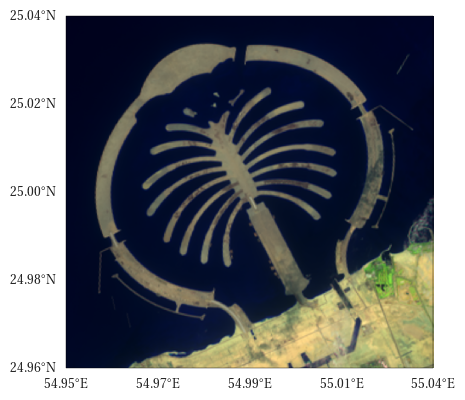

In [621]:
# get SWIR1_NIR_GREEN image
path_out = 'image_swir1_nir_green.png'

im = image.visualize(**vis)
urllib.request.urlretrieve(get_path(im), path_out)

# show image with cartopy
f=plt.figure(figsize=(10, 10))

ax2 = plt.subplot(212, projection=ccrs.GOOGLE_MERCATOR)
ax2.set_extent(extent)
ax2.set_xticks(np.linspace(xmin, xmax, 5), crs=ccrs.PlateCarree())
ax2.set_yticks(np.linspace(ymin, ymax, 5), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax2.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax2.yaxis.set_major_formatter(lat_formatter)

ax2.grid(False)

# show image
img = plt.imread(path_out)
ax2.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')


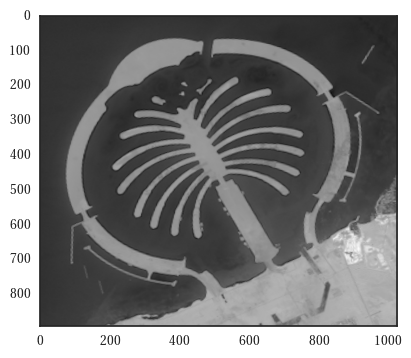

In [622]:
ndwi = image.normalizedDifference(water_bands)    

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']})
    ]).mosaic()

show(im, 'ndwi.png')

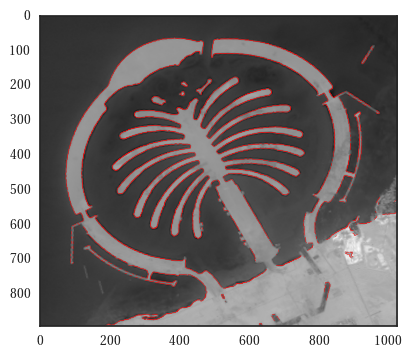

In [623]:
edge = ee.Algorithms.CannyEdgeDetector(ndwi, water_threshold, water_sigma)

# remove short edges
if removeShortEdges:
    connected = edge.mask(edge).lt(0.8).connectedPixelCount(35, True)
    edgeLong = connected.gte(35)
    edge = edgeLong

im = ee.ImageCollection.fromImages([
        ndwi.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
        edge.focal_max(1).mask(edge.focal_max(1)).visualize(**{'palette':['ff0000']})
    ]).mosaic()

show(im, 'ndwi_edges.png')

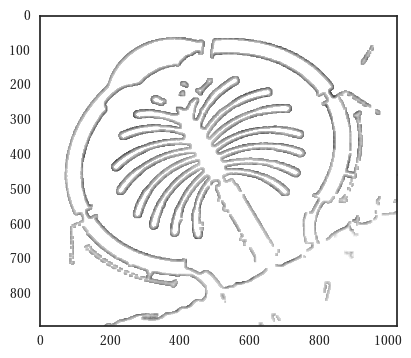

In [624]:
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

im = ee.ImageCollection.fromImages([
        ee.Image(1).visualize(**{'palette':['ffffff']}),
        ndwi_buffer.visualize(**{'min':-0.5, 'max':0.5, 'palette':['ffffff', '000000']}),
    ]).mosaic()

show(im, 'ndwi_buffer.png')

0.0990027083984


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-1, 1)

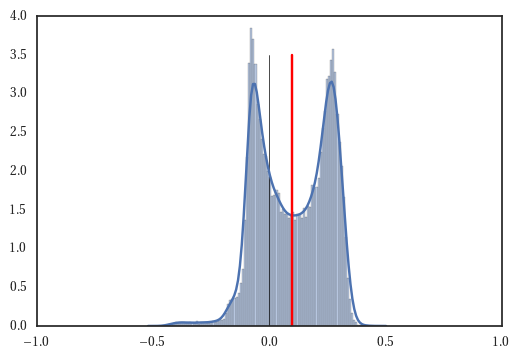

In [625]:
# local threshold

ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = ndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30).getInfo()

values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()

th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [626]:
# detect water
water = ndwi.gt(th)
water_edge = ee.Algorithms.CannyEdgeDetector(water, 0.5, 0)

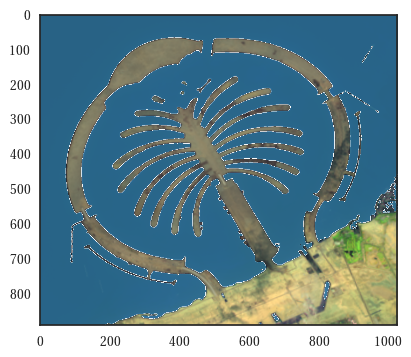

In [627]:
im = ee.ImageCollection.fromImages([
        image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
        # image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
        water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']}),
        water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
        
    ]).mosaic()

show(im, 'water_final.png')

## Figure

In [628]:
from matplotlib import rc,rcParams


params = {
    'text.usetex': True,
    'text.latex.preamble' : [
        r'\usepackage{siunitx}', r'\usepackage{amsmath}',
        # r'\usepackage[T1]{fontenc}', r'\usepackage[utf8]{inputenc}',
        r'\usepackage{lmodern}', r'\usepackage{fourier}'

        # r'\usepackage{siunitx}', r'\usepackage{amsmath}', r'\usepackage{sansmath}', '\sansmath'
    ],
    'font.family' : 'lmodern',
    'text.latex.unicode': False,
}

    
plt.rcParams.update(params)




C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


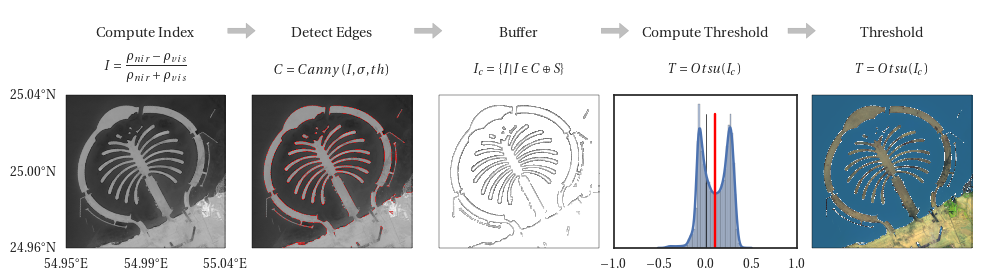

In [631]:
f = plt.figure(figsize=(12,3), dpi=600)
gs = gridspec.GridSpec(3, 5, height_ratios=[0.2,0.3,1] )

gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

    
# -------------------- row 1 (flowchart)
ax = plt.subplot(gs[0,0])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Index', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,1])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Detect Edges', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,2])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Buffer', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,3])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Compute Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')
ax.add_patch(patches.FancyArrow(x=0.95, y=0.15, dx=0.1, dy=0.0,
        width=0.05, head_length=0.05, head_width=0.15 ,clip_on=False, color='grey', alpha=0.5))

ax = plt.subplot(gs[0,4])
ax.set_axis_off()
ax.set_xlim(0,1)
ax.set_ylim(0,0.3)
ax.text(0.5, 0.1, 'Threshold', fontweight='bold', fontsize=11, horizontalalignment='center')


# ---------------------- row 2 (equations)
ax = plt.subplot(gs[1,0])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,1])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$C=Canny\left(I,\sigma,th\right)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,2])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$I_c=\left\{ I | I \in C \oplus S \right\}$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,3])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')

ax = plt.subplot(gs[1,4])
ax.set_axis_off()
ax.text(0.5, 0.5, r'$T=Otsu(I_c)$', fontsize=10, ha='center', va='center')


# -------------------- row 3 (images)
ax = plt.subplot(gs[2,0], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
ax.set_xticks(np.linspace(xmin, xmax, 3), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(ymin, ymax, 3), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.yaxis.set_major_formatter(lat_formatter)

# show image
img = plt.imread('ndwi.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')




ax = plt.subplot(gs[2,1], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_edges.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)


ax = plt.subplot(gs[2,2], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_buffer.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



ax = plt.subplot(gs[2,3])
ax.set_axis_off()
ax.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], kde_kws={'bw': 0.02})
ax.plot([th, th], [0, 3.5], 'r-')
ax.set_xlim(-1, 1)
ax.set_axis_on()
ax.yaxis.set_visible(False)
# ax.text(, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')


ax = plt.subplot(gs[2,4], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('water_final.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


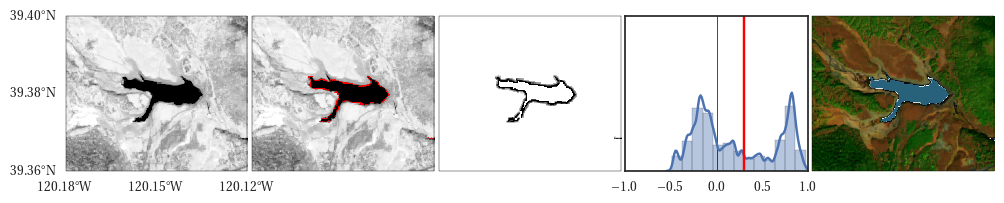

In [599]:
f = plt.figure(figsize=(12,2), dpi=600)
gs = gridspec.GridSpec(1, 5)

gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes. 

# -------------------- row 3 (images)
ax = plt.subplot(gs[0,0], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
ax.set_xticks(np.linspace(xmin, xmax, 3), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(ymin, ymax, 3), crs=ccrs.PlateCarree())

# label axes as degrees
lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.xaxis.set_major_formatter(lon_formatter)

lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
ax.yaxis.set_major_formatter(lat_formatter)

# show image
img = plt.imread('ndwi.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')




ax = plt.subplot(gs[0,1], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_edges.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)


ax = plt.subplot(gs[0,2], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('ndwi_buffer.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



ax = plt.subplot(gs[0,3])
ax.set_axis_off()
ax.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], kde_kws={'bw': 0.02})
ax.plot([th, th], [0, 3.5], 'r-')
ax.set_xlim(-1, 1)
ax.set_axis_on()
ax.yaxis.set_visible(False)
# ax.text(, r'$I=\dfrac{\rho_{nir}-\rho_{vis}}{\rho_{nir}+\rho_{vis}}$', fontsize=10, ha='center', va='center')


ax = plt.subplot(gs[0,4], projection=ccrs.GOOGLE_MERCATOR)
ax.set_extent(extent)
img = plt.imread('water_final.png')
ax.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')
ax.set_axis_on()
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)



In [630]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/water_detection_method_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()


0.246453071289


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Local thredhold:  0.302545003711


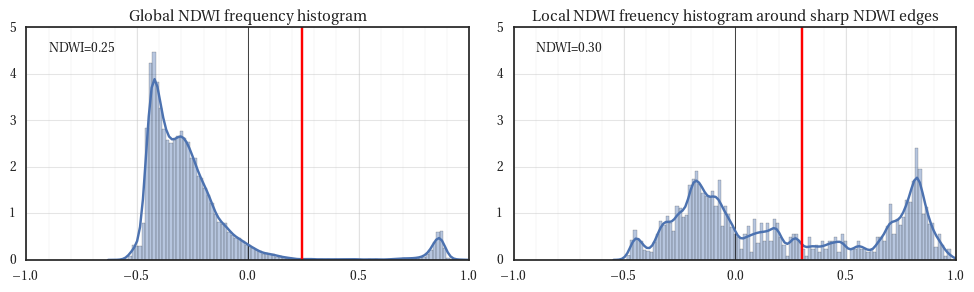

In [601]:
f = plt.figure(figsize=(12, 3))

# show global threshold
values = ndwi.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

ax1 = plt.subplot2grid((1,2),(0, 0))
ax1.plot([0, 0], [0, ndwi_hist_ymax], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02}, ax=ax1)
ax1.plot([th, th], [0, ndwi_hist_ymax], 'r-')
ax1.set_xlim(-1, 1)
ax1.set_title('Global NDWI frequency histogram')
ax1.text(-0.9, ndwi_hist_ymax * 0.9, 'NDWI=%.2f' % th)

# show local threthold
ndwi_buffer = ndwi.mask(edge.focal_max(30, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 15).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print('Local thredhold: ', th)

ax2.grid()
ax2 = plt.subplot2grid((1,2),(0, 1))
ax2.plot([0, 0], [0, ymax], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02}, ax=ax2)
ax2.plot([th, th], [0, ymax], 'r-')
ax2.set_xlim(-1, 1)
ax2.set_title('Local NDWI frequency histogram around sharp NDWI edges')
ax2.text(-0.9, ndwi_hist_ymax * 0.9, 'NDWI=%.2f' % th)


ax1.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax1.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax1.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)
ax1.yaxis.set_major_locator(plt.MultipleLocator(1))
ax1.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax1.set_ylim(0, ndwi_hist_ymax)

ax2.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax2.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax2.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75', alpha=0.4)
ax2.yaxis.set_major_locator(plt.MultipleLocator(1))
ax2.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75', alpha=0.4)
ax2.set_ylim(0, ndwi_hist_ymax)

f.subplots_adjust(wspace=0.1)


In [602]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/NDWI_hist_local_global_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()


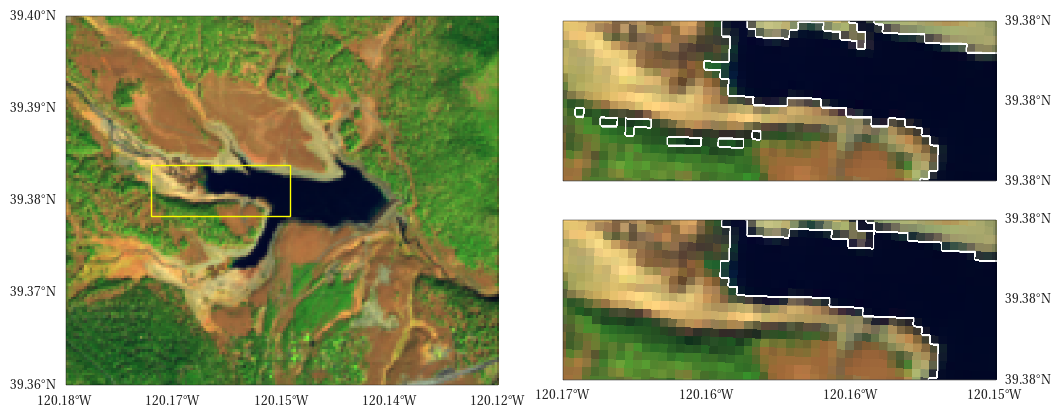

In [612]:
f = plt.figure(figsize=(12,5))

f.subplots_adjust(wspace=0.15, hspace=0.05)

ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2, projection=ccrs.GOOGLE_MERCATOR)
ax2 = plt.subplot2grid((2,2), (0,1), projection=ccrs.GOOGLE_MERCATOR)
ax3 = plt.subplot2grid((2,2), (1,1), projection=ccrs.GOOGLE_MERCATOR)

def add_ticks(ax, nx, ny, xmin, xmax, ymin, ymax):
    ax.set_axis_on()
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_xticks(np.linspace(xmin, xmax, nx), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(ymin, ymax, ny), crs=ccrs.PlateCarree())
    
    # label axes as degrees
    lon_formatter = LongitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
    ax.xaxis.set_major_formatter(lon_formatter)
    lat_formatter = LatitudeFormatter(number_format='.2f', degree_symbol='$^{\circ}$')
    ax.yaxis.set_major_formatter(lat_formatter)


# main image
#im_rgb = image.visualize(**vis_rgb)
#retrieve(im_rgb, 'fig2_main.png')

im_rgb = image.visualize(**vis)
retrieve(im_rgb, 'fig2_main.png')

ax1.set_extent(extent)
img = plt.imread('fig2_main.png')
ax1.imshow(img, transform=ccrs.PlateCarree(), extent=extent, origin='upper')

add_ticks(ax1, 5, 5, xmin, xmax, ymin, ymax)


bounds = shape(geometry_inset.bounds().getInfo())
coords = list(bounds.boundary.coords)
xmin2 = coords[0][0]
xmax2 = coords[1][0]
ymin2 = coords[0][1]
ymax2 = coords[2][1]

extent2 = (xmin2, xmax2, ymin2, ymax2)

import matplotlib.patches as mpatches
ax1.add_patch(mpatches.Rectangle(xy=[xmin2, ymin2], width=xmax2-xmin2, height=ymax2-ymin2,
                                facecolor='None',
                                edgecolor='yellow',
                                lw=1,
                                transform=ccrs.PlateCarree())
             )


# NDWI = 0
edge = ee.Algorithms.CannyEdgeDetector(ndwi.gt(0), 1, 0)
ndwi_zero = edge.mask(edge).focal_max(1)

im = ee.ImageCollection.fromImages([
        im_rgb,
        ndwi_zero.visualize(**{'palette': 'ffffff'}),
    ]).mosaic()

thumb_url = im.getThumbURL({'region' : geometry_inset.getInfo(), 'format': 'png', 'dimensions': 800})
urllib.request.urlretrieve(thumb_url, 'fig2_ur.png')
    
img = plt.imread('fig2_ur.png')
ax2.set_extent(extent2)
ax2.imshow(img, transform=ccrs.PlateCarree(), extent=extent2, origin='upper')
ax2.set_axis_on()
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)

add_ticks(ax2, 4, 3, xmin2, xmax2, ymin2, ymax2)
ax2.xaxis.set_ticks([])
ax2.yaxis.tick_right()

# NDWI dynamic
edge = ee.Algorithms.CannyEdgeDetector(water, 1, 0)
ndwi_dynamic = edge.mask(edge).focal_max(1)

im = ee.ImageCollection.fromImages([
        im_rgb,
        ndwi_dynamic.visualize(**{'palette': 'ffffff'}),
    ]).mosaic()

thumb_url = im.getThumbURL({'region' : geometry_inset.getInfo(), 'format': 'png', 'dimensions': 800})
urllib.request.urlretrieve(thumb_url, 'fig2_lr.png')

img = plt.imread('fig2_lr.png')
ax3.set_extent(extent2)
ax3.imshow(img, transform=ccrs.PlateCarree(), extent=extent2, origin='upper')
ax3.set_axis_on()
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)

add_ticks(ax3, 4, 3, xmin2, xmax2, ymin2, ymax2)
ax3.yaxis.tick_right()

#plt.tight_layout()


In [613]:
# save as high-dpi image
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages(r'../figures/water_detection_method_zoom_' + suffix + '.pdf')
pdf.savefig(figure=f, bbox_inches='tight', dpi=600)
pdf.close()


## Resampled and original image

In [ ]:
# show histogram around edges *without* resampling (scale=20)
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")

image = images \
    .filterBounds(geometry) \
    .filterDate('2014-01-01', '2015-01-01') \
    .reduce(ee.Reducer.percentile([25])) \
    .rename(ee.Image(images.first()).bandNames())
    
ndwi = image.normalizedDifference(['B3', 'B5'])    
edge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 1)
ndwi_buffer = ndwi.mask(edge.focal_max(20, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 20).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 9], 'k-', lw=0.5)

sns.distplot(values['nd'], bins=100)
plt.plot([th, th], [0, 9], 'r-')
plt.xlim(-1, 1)


In [ ]:
# show histogram around edges *with* resampling (scale=20)
images = ee.ImageCollection("LANDSAT/LC8_L1T_TOA")

image = images \
    .filterBounds(geometry) \
    .filterDate('2014-01-01', '2015-01-01') \
    .map(lambda i: i.resample('bicubic')) \
    .reduce(ee.Reducer.percentile([25])) \
    .rename(ee.Image(images.first()).bandNames())
    
ndwi = image.normalizedDifference(['B3', 'B5'])    
edge = ee.Algorithms.CannyEdgeDetector(ndwi, 0.5, 1)
ndwi_buffer = ndwi.mask(edge.focal_max(20, 'square', 'meters'))
values = ndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 20).getInfo()
th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 9], 'k-', lw=0.5)

sns.distplot(values['nd'], bins=100)
plt.plot([th, th], [0, 9], 'r-')
plt.xlim(-1, 1)
